<a href="https://colab.research.google.com/github/softmurata/prompt-engineering/blob/main/sgwork/CRUDAPI%2BInpaintAnything.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Oneformer Installation

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 80.9 MB/s eta 0:00:00


Inpaint Anything Installation

In [ ]:
# Installation
%cd /content
 
!git clone https://github.com/geekyutao/Inpaint-Anything.git
 
%cd /content/Inpaint-Anything
# Commits on Apr 24, 2023
!git checkout 6bf630535c9e3f06e01c0af63f2e206f38483c7c

# torchtext.legacy solve: https://github.com/Stability-AI/stablediffusion/issues/8
%cd /content/Inpaint-Anything
 
!pip uninstall yellowbrick imbalanced-learn -y
!python -m pip install -e segment_anything
!python -m pip install pyyaml tqdm easydict==1.9.0 scikit-image scikit-learn albumentations==0.5.2 hydra-core==1.1.0 pytorch-lightning==1.8.3.post0 tabulate kornia==0.5.0 webdataset packaging wldhx.yadisk-direct
!python -m pip install yellowbrick imbalanced-learn
!pip install huggingface-hub

# download pretrained models
%cd /content/Inpaint-Anything
 
!mkdir -p pretrained_models
 
!wget -c https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth \
      -O ./pretrained_models/sam_vit_h_4b8939.pth
 
# ダウンロード不安定なためHuggingFace使用
# !curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip
# !unzip big-lama.zip
# !mv big-lama ./pretrained_models
!mkdir -p pretrained_models/big-lama/models
!wget -c https://huggingface.co/camenduru/big-lama/resolve/main/big-lama/models/best.ckpt \
      -O pretrained_models/big-lama/models/best.ckpt
!wget -c https://huggingface.co/camenduru/big-lama/raw/main/big-lama/config.yaml \
      -O pretrained_models/big-lama/config.yaml

In [ ]:
%cd /content/Inpaint-Anything

/content/Inpaint-Anything


In [ ]:
import os
import sys
from pathlib import Path
sys.path.insert(0,  "/content/Inpaint-Anything/lama")
from saicinpainting.evaluation.utils import move_to_device
from saicinpainting.training.trainers import load_checkpoint
from saicinpainting.evaluation.data import pad_tensor_to_modulo

from omegaconf import OmegaConf
import torch
import yaml
import cv2

Detectron v2 is not installed


Load model

In [ ]:
def load_remove_model(lama_config, lama_ckpt, device):
  predict_config = OmegaConf.load(lama_config)
  predict_config.model.path = lama_ckpt
  # device = torch.device(predict_config.device)
  device = torch.device(device)

  train_config_path = os.path.join(
      predict_config.model.path, 'config.yaml')

  with open(train_config_path, 'r') as f:
      train_config = OmegaConf.create(yaml.safe_load(f))

  train_config.training_model.predict_only = True
  train_config.visualizer.kind = 'noop'

  checkpoint_path = os.path.join(
        predict_config.model.path, 'models',
        predict_config.model.checkpoint
  )
  model = load_checkpoint(
          train_config, checkpoint_path, strict=False, map_location='cpu')
  model.freeze()
  if not predict_config.get('refine', False):
      model.to(device)
  return model, predict_config

In [ ]:
lama_config = "lama/configs/prediction/default.yaml"
lama_ckpt = "./pretrained_models/big-lama"
device = "cuda" if torch.cuda.is_available() else "cpu"
remove_model, predict_config = load_remove_model(lama_config, lama_ckpt, device)

Preprocess for oneformer


In [ ]:
from transformers import AutoProcessor, BlipForConditionalGeneration
from transformers import CLIPProcessor, CLIPModel
from transformers import OneFormerProcessor, OneFormerForUniversalSegmentation
from PIL import Image
import cv2
import json
import pycocotools.mask as mask_util
import numpy as np
import torch

In [ ]:
def extract_good_bbox(predicted_semantic_map, label_id, threshold_resol=10):
  pred_semantic_map = predicted_semantic_map.cpu().numpy()
  m = np.where(pred_semantic_map==label_id, 1, 0)
  mh, mw = m.shape[:2]
  mask = np.ascontiguousarray(m)  # some versions of cv2 does not support incontiguous arr
  res = cv2.findContours(mask.astype("uint8"), cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
  hierarchy = res[-1]
  has_holes = (hierarchy.reshape(-1, 4)[:, 3] >= 0).sum() > 0
  res = res[-2]
  res = [x.flatten() for x in res]
  # These coordinates from OpenCV are integers in range [0, W-1 or H-1].
  # We add 0.5 to turn them into real-value coordinate space. A better solution
  # would be to first +0.5 and then dilate the returned polygon by 0.5.
  polygons = [x + 0.5 for x in res if len(x) >= 6]
  candidate_bboxes = []
  for pol_id in range(len(polygons)):
    p = mask_util.frPyObjects([polygons[pol_id]], mh, mw)
    p = mask_util.merge(p)
    bbox = mask_util.toBbox(p)
    if bbox[2] < threshold_resol or bbox[3]< threshold_resol:
      continue
    
    bbox[2] += bbox[0]
    bbox[3] += bbox[1]
    candidate_bboxes.append([pol_id, bbox])

  return candidate_bboxes

In [ ]:
# Load Oneformer model
oneformer_model_name = "shi-labs/oneformer_ade20k_swin_large"
oneformer_ade20k_processor = OneFormerProcessor.from_pretrained(
            oneformer_model_name,
)
oneformer_ade20k_model = OneFormerForUniversalSegmentation.from_pretrained(
            oneformer_model_name,
).to(device)

/usr/local/lib/python3.10/dist-packages/transformers/models/oneformer/image_processing_oneformer.py:417: FutureWarning: The `reduce_labels` argument is deprecated and will be removed in v4.27. Please use `do_reduce_labels` instead.
  warnings.warn(


In [ ]:
# prerequisities
ade20k_names_dict = oneformer_ade20k_model.config.id2label
ade20k_label_id_dict = oneformer_ade20k_model.config.label2id


## normal inference function ##
def normal_inference_with_oneformer(image, label_name, threshold_resol=40):
  inputs = oneformer_ade20k_processor(images=image, task_inputs=["semantic"], return_tensors="pt").to(device)

  with torch.no_grad():
    outputs = oneformer_ade20k_model(**inputs)
  predicted_semantic_map = oneformer_ade20k_processor.post_process_semantic_segmentation(
          outputs, target_sizes=[image.size[::-1]])[0]
  # label_name = "lamp"  # chair, sofa, plant. shelf, "painting, picture"
  label_id = ade20k_label_id_dict[label_name]
  cand_bboxes = extract_good_bbox(predicted_semantic_map, label_id, threshold_resol)
  if len(cand_bboxes) > 0:
    print(cand_bboxes)

  # display image
  temp_image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  for pol_id, bbox in cand_bboxes:
    left_point = (int(bbox[0]), int(bbox[1]))
    right_point = (int(bbox[2]), int(bbox[3]))
    text_offset = 20
    middle_point = (int(left_point[0] * 0.5 + right_point[0] * 0.5) - text_offset, int(left_point[1] * 0.5 + right_point[1] * 0.5 ))
    cv2.rectangle(temp_image, left_point, right_point, (255, 0, 0), 5)
    cv2.putText(temp_image,
                text=f"{pol_id}: {ade20k_names_dict[label_id]}",
                org=middle_point,
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(255, 0, 0),
                thickness=2,
                lineType=cv2.LINE_4)
  return Image.fromarray(temp_image)


## partial inference function ##
def preprocess_for_bg_img(img_path, part):
  # ToDo: change part json
  padding_mask_json = {
    "center": [0.3, 0.7],
    "left": [0, 0.4],
    "right": [0.7, 1]
  }
  base_img = cv2.imread(img_path)
  bh, bw = base_img.shape[:2]
  pad_bbox = padding_mask_json[part]
  pad_img = base_img[:, int(pad_bbox[0] * bw):int(pad_bbox[1] * bw), :]
  bg_img = np.zeros_like(base_img)
  bg_img[:, int(pad_bbox[0] * bw):int(pad_bbox[1] * bw), :] = pad_img
  bg_img = Image.fromarray(bg_img)
  return bg_img
def partial_inference_with_oneformer(bg_img, temp_image, object_name, threshold_resol=40, ablate_ratio=0.02):
  inputs = oneformer_ade20k_processor(images=bg_img, task_inputs=["semantic"], return_tensors="pt").to(device)

  with torch.no_grad():
    outputs = oneformer_ade20k_model(**inputs)
  predicted_semantic_map = oneformer_ade20k_processor.post_process_semantic_segmentation(
          outputs, target_sizes=[bg_img.size[::-1]])[0]

  label_name = ""
  for id, value in ade20k_names_dict.items():
    value_list = value.split(",")
    value_list = [v.split(" ")[-1] for v in value_list]
    if object_name in value_list:
      label_name = value
      break

  label_id = ade20k_label_id_dict[label_name]
  cand_bboxes = extract_good_bbox(predicted_semantic_map, label_id, threshold_resol)
  if len(cand_bboxes) > 0:
    print(cand_bboxes)

  # display image
  mask_image = np.zeros_like(temp_image)

  for pol_id, bbox in cand_bboxes:
    left_point = (int(bbox[0] * (1 - ablate_ratio)), int(bbox[1] * (1 - ablate_ratio)))
    right_point = (int(bbox[2] * (1 + ablate_ratio)), int(bbox[3] * (1 + ablate_ratio)))
    text_offset = 20
    middle_point = (int(left_point[0] * 0.5 + right_point[0] * 0.5) - text_offset, int(left_point[1] * 0.5 + right_point[1] * 0.5 ))
    cv2.rectangle(temp_image, left_point, right_point, (255, 0, 0), 5)
    cv2.rectangle(mask_image, left_point, right_point, (255, 255, 255), -1)
    cv2.putText(temp_image,
                text=f"{pol_id}: {ade20k_names_dict[label_id]}",
                org=middle_point,
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.5,
                color=(255, 0, 0),
                thickness=2,
                lineType=cv2.LINE_4)
  return Image.fromarray(temp_image), Image.fromarray(mask_image)
  
  

In [ ]:
# image
img_path = "/content/room001.jpeg"
# prompt
method = "delete"
part = "center"
object_name = "shelf"
image = Image.open(img_path)
temp_image = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

In [ ]:
# normal inference
res_image = normal_inference_with_oneformer(image, "lamp", 40)
display(res_image)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[[3, array([516., 223., 703., 536.])], [4, array([546., 383., 601., 432.])], [5, array([605., 379., 654., 427.])]]


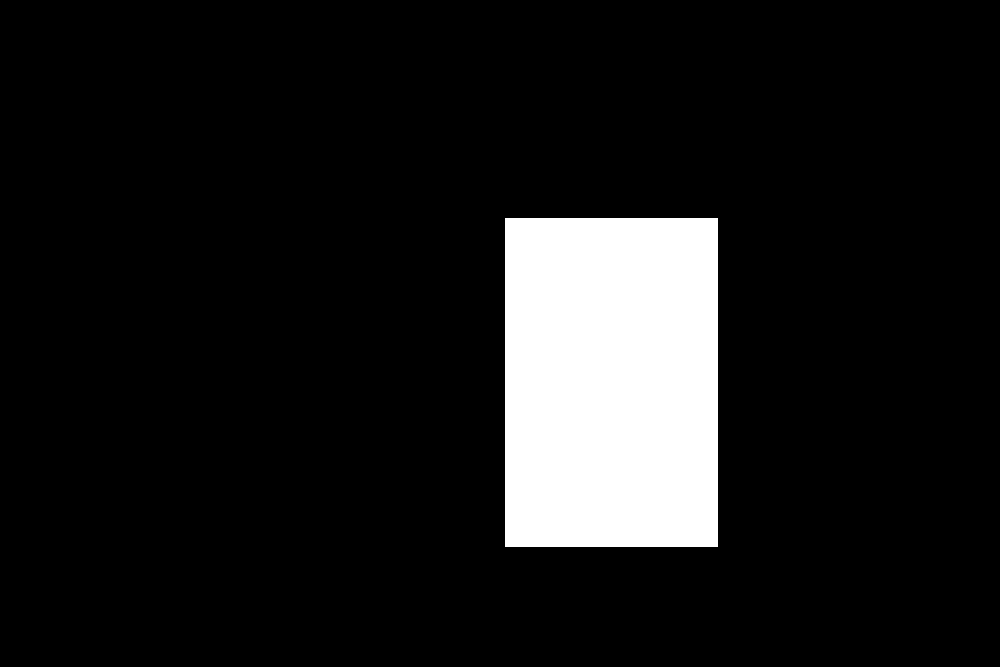

In [ ]:
# partial inference
bg_img = preprocess_for_bg_img(img_path, part)
rgb_image, mask_image = partial_inference_with_oneformer(bg_img, temp_image, object_name)
display(mask_image)

In [ ]:
mask_image.save("/content/room001_mask.png")

Delete API Inference

In [ ]:
img_path = "/content/room001.jpeg"
mask_img_path = "/content/room001_mask.png"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # bgr image
mask = cv2.cvtColor(cv2.imread(mask_img_path), cv2.COLOR_BGR2GRAY)  # oneformer mask

In [ ]:
def delete_api_function(img, mask, model, predict_config, mod=8):
  batch = {}
  if np.max(mask) == 1:
    mask = mask * 255
  img = torch.from_numpy(img).float().div(255.)
  mask = torch.from_numpy(mask).float()
  batch['image'] = img.permute(2, 0, 1).unsqueeze(0)
  batch['mask'] = mask[None, None]
  unpad_to_size = [batch['image'].shape[2], batch['image'].shape[3]]
  batch['image'] = pad_tensor_to_modulo(batch['image'], mod)
  batch['mask'] = pad_tensor_to_modulo(batch['mask'], mod)
  batch = move_to_device(batch, device)
  batch['mask'] = (batch['mask'] > 0) * 1

  batch = model(batch)
  cur_res = batch[predict_config.out_key][0].permute(1, 2, 0)
  cur_res = cur_res.detach().cpu().numpy()

  if unpad_to_size is not None:
    orig_height, orig_width = unpad_to_size
    cur_res = cur_res[:orig_height, :orig_width]

  cur_res = np.clip(cur_res * 255, 0, 255).astype('uint8')

  return cur_res


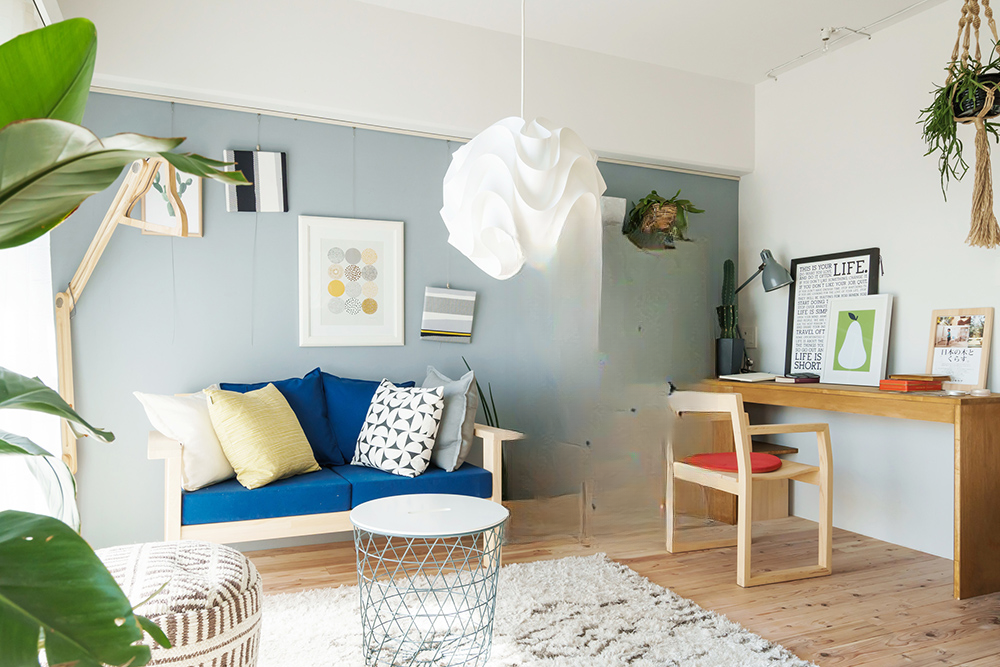

In [ ]:
cur_res = delete_api_function(img, mask, remove_model, predict_config)
display(Image.fromarray(cur_res))

Replace API Inference 

In [ ]:
!pip install diffusers transformers accelerate bitsandbytes safetensors

In [ ]:
%cd /content/Inpaint-Anything/

In [ ]:
import torch
import cv2
from PIL import Image
import numpy as np
from diffusers import StableDiffusionInpaintPipeline
from utils.mask_processing import crop_for_filling_pre, crop_for_filling_post

In [ ]:
def load_replace_model(model_name, device):
  pipe = StableDiffusionInpaintPipeline.from_pretrained(
        model_name,
        torch_dtype=torch.float16,
  ).to(device)
  return pipe

In [ ]:
# Load stable diffusion inpainting model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "stabilityai/stable-diffusion-2-inpainting"
pipe = load_replace_model(model_name, device)

In [ ]:
## Input
text_prompt = "a tall european bookshelf"
img_path = "/content/room001.jpeg"
mask_img_path = "/content/room001_mask.png"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)  # bgr image
mask = cv2.cvtColor(cv2.imread(mask_img_path), cv2.COLOR_BGR2GRAY)  # oneformer mask

In [ ]:
img_crop, mask_crop = crop_for_filling_pre(img, mask)
img_crop_filled = pipe(
        prompt=text_prompt,
        image=Image.fromarray(img_crop),
        mask_image=Image.fromarray(mask_crop)
).images[0]
img_filled = crop_for_filling_post(img, mask, np.array(img_crop_filled))

  0%|          | 0/50 [00:00<?, ?it/s]

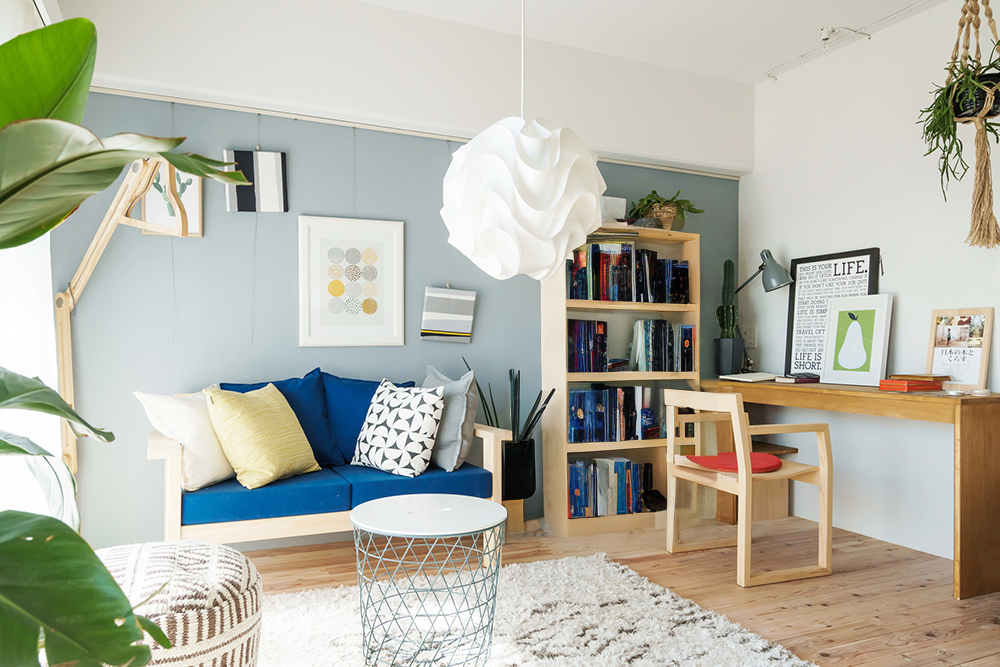

In [ ]:
display(Image.fromarray(img_filled))